Problem Statement : 
    
    The Red Sox are in panic mode, and they just hired you for a million dollar salary to build
    data analytics for them to predict best possible batting order to beat the Yankees.Build the 
    most appropriate model and predict the batting ranks of Red Sox.   

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
sns.set_context('notebook')

RANDOM_SEED = 20090425


C:\Users\nikhi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The dataset is formed manually by referring multiple MLB sites such as 
http://www.espn.com/mlb/team/stats/batting/_/name/bos   
https://www.foxsports.com/mlb/boston-red-sox-team-stats

We have considered the data frame having various paramters of RedSox players against multiple games.

Lets upload the data set here.


Few Terminologies with their meaning : 

OPS:On-base plus slugging is a sabermetric baseball statistic calculated as the sum of a player's on-base percentage and slugging average. 


PA:In baseball statistics, a player is credited with a plate appearance (denoted by PA) each time he completes a turn batting.  


HR:a home run (abbreviated HR) is scored when the ball is hit in such a way that the batter is able to circle the bases and reach home safely in one play without any errors being committed by the defensive team in the process.  


ISO:Isolated Power or ISO is a sabermetric computation used to measure a batter's raw power.  


WAR:Wins Above Replacement (WAR) is an attempt by the sabermetric baseball community to summarize a player's total contributions to their team in one statistic. You should always use more than one metric at a time when evaluating players, but WAR is all-inclusive and provides a useful reference point for comparing players.  


wOBA:wOBA is a statistic, based on linear weights, designed to measure a player's overall offensive contributions per plate appearance.


In [2]:
try: 
    baseball = pd.read_csv('data/P_STATS.csv')
except:
    baseball = pd.read_csv(pm.get_data('data/P_STATS.csv'))

In [3]:
baseball['OPS'] = baseball.OBP + baseball.SLG

In [4]:
baseball

,#,Name,G,PA,HR,R,RBI,SB,BB,K,...,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR,OPS
0,1,Mookie Betts,136,614,32,129,80,30,13.200,14.800,...,0.346,0.438,0.640,0.449,185,6.9,79.1,11.6,10.4,1.078
1,2,J.D. Martinez,150,649,43,111,130,6,0.106,0.225,...,0.330,0.402,0.629,0.427,170,-4.1,60.2,-14.7,5.9,1.031
2,3,Xander Bogaerts,136,580,23,72,103,8,0.095,0.176,...,0.288,0.360,0.522,0.373,133,-1.7,31.0,7.2,4.9,0.882
3,4,Andrew Benintendi,148,661,16,103,87,21,0.107,0.160,...,0.290,0.366,0.465,0.357,122,4.3,31.9,-1.5,4.3,0.831
4,5,Jackie Bradley Jr.,144,535,13,76,59,17,0.086,0.256,...,0.234,0.314,0.403,0.310,90,5.7,9.4,10.1,2.8,0.717
5,6,Brock Holt,109,367,7,41,46,7,0.101,0.199,...,0.277,0.362,0.411,0.338,109,-4.8,9.3,2.3,1.4,0.773
6,7,Steve Pearce,50,165,7,19,26,0,0.133,0.164,...,0.279,0.394,0.507,0.387,143,1.2,19.6,-3.0,1.2,0.901
7,8,Rafael Devers,121,490,21,59,66,5,0.078,0.247,...,0.240,0.298,0.433,0.310,90,2.2,6.3,-3.0,1.0,0.731
8,9,Mitch Moreland,124,459,15,57,68,2,0.109,0.222,...,0.245,0.325,0.433,0.325,100,-4.1,6.2,-5.1,0.6,0.758
9,10,Rick Porcello,33,7,0,1,3,0,0.000,0.429,...,0.429,0.429,0.714,0.482,207,0.0,10.9,0.8,0.2,1.143


WAR of a player is directly related to the Winning probability of a team. A High WAR value means 
the player has a high contribution in Winning matches.  
Lets find the correlation of WAR with respect to other parameters -

In [6]:
baseball.corr()['WAR'].sort_values()

#       -0.871013
BABIP    0.095832
Def      0.281956
BsR      0.371997
AVG      0.384114
SLG      0.529223
wOBA     0.570288
wRC+     0.571763
OPS      0.574252
OBP      0.594173
ISO      0.600425
G        0.690454
RBI      0.737292
K        0.749708
PA       0.749785
BB       0.758016
SB       0.819905
HR       0.820388
R        0.888944
Off      0.945315
WAR      1.000000
Name: WAR, dtype: float64

lets find the correlation of Runs with respect to other parameters - 

In [8]:
baseball.corr()['R'].sort_values()

#       -0.903390
BABIP    0.023339
Def      0.085318
BsR      0.296123
AVG      0.334288
OBP      0.413623
wOBA     0.463308
wRC+     0.465171
SLG      0.498010
OPS      0.504757
K        0.507636
BB       0.520553
ISO      0.590166
Off      0.779140
SB       0.810682
WAR      0.888944
HR       0.897947
RBI      0.904174
G        0.913627
PA       0.951090
R        1.000000
Name: R, dtype: float64

As per the above correlation with the WAR/Runs, we found that Off, HR, PA, wOBA and ISO 
are the best parameters to be considered in order to predict expected scores 
and inturn connection of each player to winning probability of the team.

Now Lets Plot few things and see where our players stand!!!! 

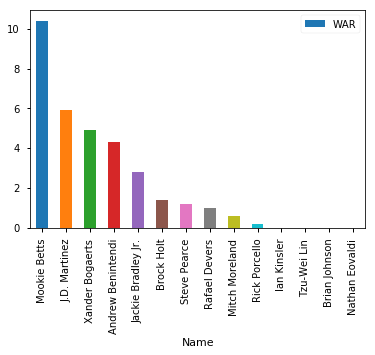

In [8]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='WAR', kind='bar') 
plt.show()

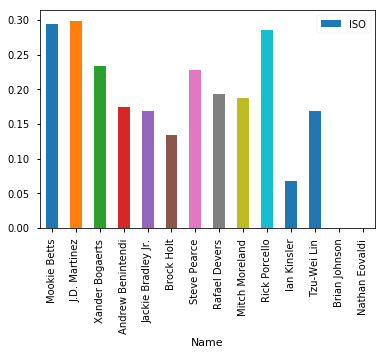

In [9]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='ISO', kind='bar') 
plt.show()

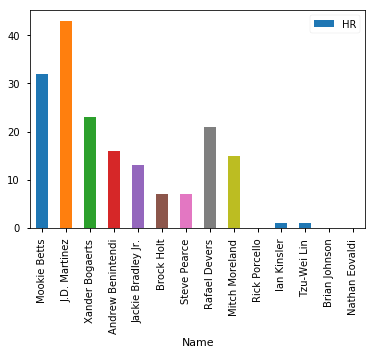

In [10]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='HR', kind='bar') 
plt.show()

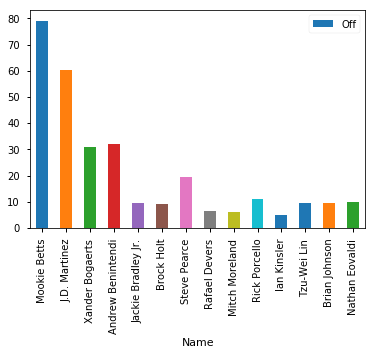

In [11]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='Off', kind='bar') 
plt.show()

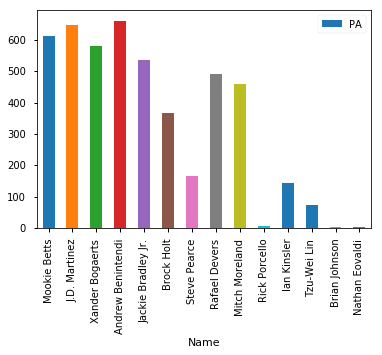

In [12]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='PA', kind='bar') 
plt.show()

Few More Plots !! 

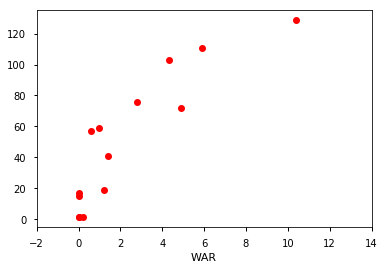

In [14]:
baseball.plot(x='WAR', y='R', style='ro', legend=False, xlim=(-2,14));

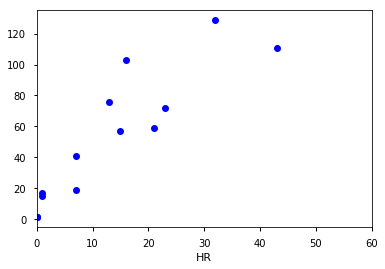

In [18]:
baseball.plot(x='HR', y='R', style='bo', legend=False, xlim=(0,60));

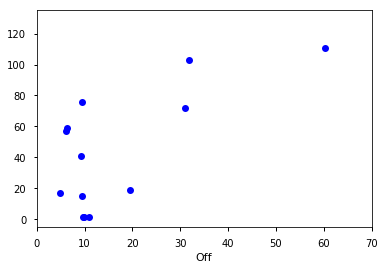

In [22]:
baseball.plot(x='Off', y='R', style='bo', legend=False, xlim=(0,70));

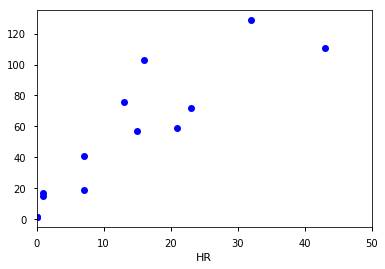

In [23]:
baseball.plot(x='HR', y='R', style='bo', legend=False, xlim=(0,50));

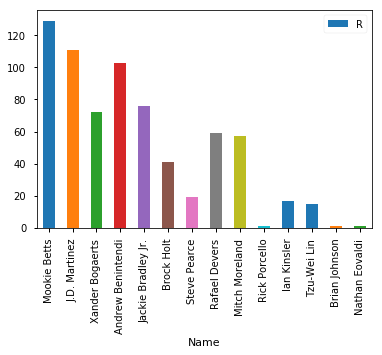

In [24]:
#Redsox_df.Average.hist(normed=True, bins=14)
baseball.plot(x='Name', y='R', kind='bar') 
plt.show()

Priors
The first step in specifying our model is to specify priors for our model.

Lets use a linear model for μ, with an intercept (bias) factor and 5 linear factors slope1,slope2,
slope3,slope4 and slope5 to represent PA, HR, ISO, WAR and wOBA:

μ=intercept+slope1∗x+slope2∗z
 
We are going to model these factors as normal distributions with a wide support:

∼Normal(0,100)
 
and finally the standard deviation of our modelled Points will be a half Cauchy:

σ∼HalfCauchy(1)
 
Since we want to track slope1,slope2,slope3,slope4 and slope5 we need to add them as deterministic variables of our model: pm.Deterministic.

In [68]:
N = len(baseball.WAR)
from pymc3 import Normal, HalfCauchy, Deterministic, Model
with pm.Model() as baseball_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope1 = Normal('slope1', 0, sd=100)
    slope2 = Normal('slope2', 0, sd=100)
    slope3 = Normal('slope3', 0, sd=100)
    slope4 = Normal('slope4', 0, sd=100)
    slope5 = Normal('slope5', 0, sd=100)
    

In [69]:
with baseball_model:
    
    pa = Deterministic('pa', slope1)
    war = Deterministic('war', slope2)
    woba = Deterministic('woba', slope3)
    iso = Deterministic('iso', slope4)
    hr = Deterministic('hr', slope5)
    σ = HalfCauchy('σ', 1)
   

In [70]:
with baseball_model:
    
    μ = intercept + slope1*baseball.PA + slope2*baseball.WAR + slope3*baseball.wOBA + slope4*baseball.ISO + slope5*baseball.HR
    score = Normal('score', μ, sd=σ, observed=baseball.R)

All right! Now our regression model is fully specified and you are ready to track your posteriors.

You can now use the fitting method of your choice to estimate a posterior distribution. Let's use a Markov chain Monte Carlo algorithm, called NUTS (the No U-Turn Sampler).

In [71]:
from pymc3 import sample

with baseball_model:

    baseball_sample = sample(2500, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, hr, iso, woba, war, pa, intercept]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:54<00:00, 218.74draws/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Let's plot posteriors : 

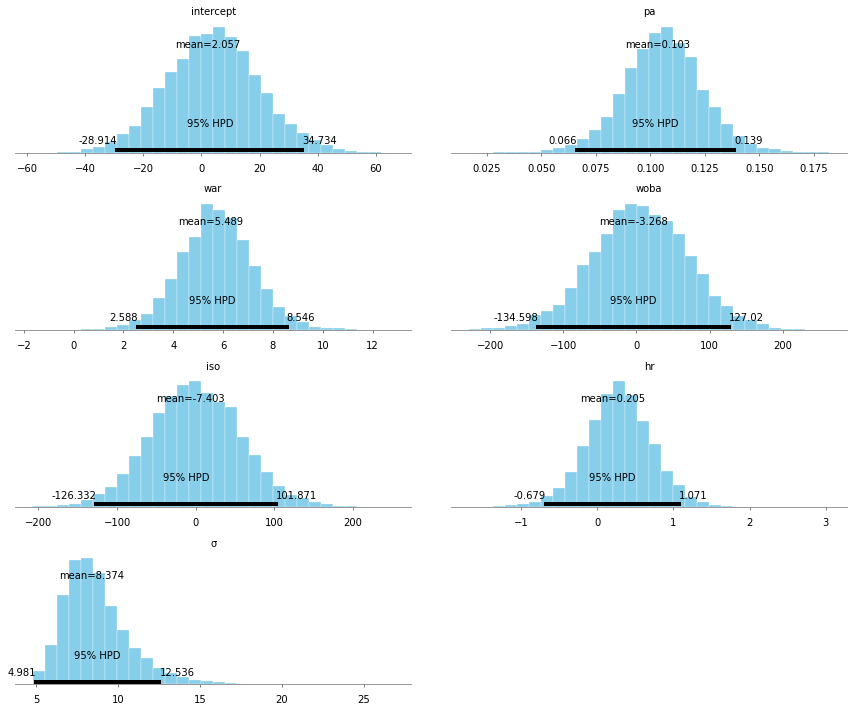

In [72]:
from pymc3 import plot_posterior

plot_posterior(baseball_sample);

#Checking model fit

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

In [73]:
from pymc3 import sample_ppc

with baseball_model:
    
    baseball_ppc = sample_ppc(baseball_sample, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 659.04it/s]


In [74]:
baseball_ppc['score']

array([[129.17826624, 118.56200258,  85.37086266, ...,  19.31192944,
          5.11656179,  -1.14852531],
       [134.20358202, 115.84867423,  86.08340673, ...,  21.8003144 ,
          1.50531255,  -1.16846653],
       [154.55324193, 106.97882062, 104.75480089, ...,  -4.51327122,
          0.63564848,  -6.81989118],
       ...,
       [143.03770376, 107.14419352, 101.76592662, ...,   2.80021915,
          5.08406965,   9.06462461],
       [140.47496649, 101.0509572 ,  93.79399803, ...,  21.47605941,
          5.34218426,  12.09866918],
       [104.80068696, 106.39509068,  91.74743777, ...,  21.86633292,
         10.59278679,  19.77564512]])

In [75]:
len(baseball_ppc['score'])

1000

In [76]:
len(baseball_ppc['score'][0])

14

We can now compare these simulated data to the data we used to fit the model.

The model should prove that it could have been used to generate the game data that we observed.

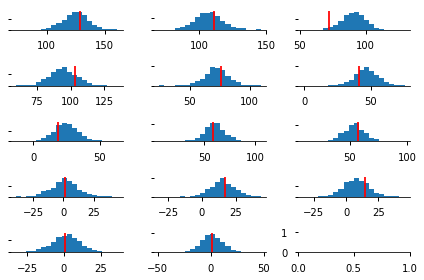

In [78]:
fig, axes = plt.subplots(5, 3)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:], baseball.R, baseball_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

#axes_flat[-1].axis('off')
plt.tight_layout()

Looks Good! 

What is the interval for the likely values for the PAs, WAR etc?

In [115]:
import pymc3 as pm
pm.stats.hpd(baseball_sample['pa'])

array([0.06636808, 0.13851208])

In [94]:
pm.stats.hpd(baseball_sample['war'])

array([2.58774123, 8.54613703])

Lets calculate quantiles for parameters - 

In [96]:
pm.stats.quantiles(baseball_sample['pa'])

{2.5: 0.0670737323722508,
 25: 0.09164084111208261,
 50: 0.10322821835126209,
 75: 0.11463436530541316,
 97.5: 0.1393764774412441}

In [97]:
pm.stats.quantiles(baseball_sample['woba'])

{2.5: -136.95477220301498,
 25: -46.334264047915646,
 50: -3.3007713443171696,
 75: 41.720058523183994,
 97.5: 125.60040077029349}

In [99]:
pm.stats.quantiles(baseball_sample['iso'])

{2.5: -120.87085001999797,
 25: -46.452621731485124,
 50: -8.513025953389343,
 75: 31.718069822130488,
 97.5: 108.21579565643958}

Now, From the sample scores , lets figure out the mean score for each of the 14 players and see which have the highest expected scores
taking into consideration all the other 5 parameters - 

In [111]:
sum_score= sum(baseball_ppc['score'])
mean_score= sum_score/1000
mean_score

array([125.00294896, 107.0331869 ,  90.69283132,  94.45681261,
        72.37986245,  46.70965739,  24.6800079 ,  60.36217747,
        53.6037933 ,   0.78700982,  15.22244691,   7.9827823 ,
         1.45438008,   1.06595505])

Conclusion : 

We check the expected score(calculated using 5 different parameters) of each player in 'mean_score' 
variable and arrange the players in batting order using the below criteria : 
    
    Batting Pos #1 : 3RD BEST
    Batting Pos #2 : 4TH BEST
    Batting Pos #3 : BEST SCORER/HITTER
    Batting Pos #4 : 2ND BEST
    Batting Pos #5 : 5TH BEST
    Batting Pos #6 : 6TH BEST
    Batting Pos #7 : 7TH BEST
    Batting Pos #8 : 8TH BEST
    Batting Pos #9 : 9TH BEST
    

    #1st : Xander Bogarts
    #2nd : Andrew Benintendi
    #3rd : Mookie Battes
    #4th : J.D.Martinez
    #5th : Jackie Bradley Jr
    #6th : Rafael Devers
    #7th : Mitch Morland
    #8th : Brock Holt
    #9th : Steve Pearce

